In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread
from textwrap import wrap
def add_gaussian_noise(im,prop,varSigma):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    e = varSigma*np.random.randn(np.prod(im.shape)).reshape(im.shape)
    im2 = np.copy(im)
    im2[index] = im2[index] + e[index]
    return im2
def add_saltnpepper_noise(im,prop):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    im2 = np.copy(im)
    im2[index] = 1-im2[index]
    return im2

def heightWidth(image):
    #width is the bigger one, the second one
    return image.shape[0], image.shape[1]

def shrink_corrupt_images(image, prop, varSigma):
    image = image/255
    image_G = add_gaussian_noise(image, prop, varSigma)
    image_S = add_saltnpepper_noise(image, prop)
    return image, image_G, image_S

def create_corrupt_titles(prop, varSigma, num):
    title1 = "Image, original"
    title2 = "Image after corruption with Gaussian noise, " + str(int(100*prop)) + "% of the pixels altered with variance = " + str(varSigma)
    title3 = "Image after corruption with salt-n-pepper noise, " + str(int(100*prop)) + "% of the pixels altered"
    return title1, title2, title3

def create_denoise_titles(num, iterations, random):
    title1 = "Image after corruption with Gaussian noise and subsequent Gibbs denoising, with " + str(iterations) + " iterations"
    title2 = "Image after corruption with salt-n-pepper noise and subsequent Gibbs denoising, with " + str(iterations) + " iterations"
    if(random == True):
        title1 = title1 + ", using random sampling"
        title2 = title2 + ", using random sampling"
    return title1, title2

def display_three_images(image1, title1, image2, title2, image3, title3):    
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(131)
    ax1.set_title("\n".join(wrap(title1, 35)))
    ax1.axis('off')
    ax1.imshow(image1,cmap='gray')
    
    ax2 = fig.add_subplot(132)
    ax2.set_title("\n".join(wrap(title2, 35)))
    ax2.axis('off')
    ax2.imshow(image2,cmap='gray')
    
    ax3 = fig.add_subplot(133)
    ax3.set_title("\n".join(wrap(title3, 35)))
    ax3.axis('off')
    ax3.imshow(image3,cmap='gray')
    
    plt.show()
    
def save_three_images(image1, title1, image2, title2, image3, title3, fpath):    
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(131)
    ax1.set_title("\n".join(wrap(title1, 35)))
    ax1.axis('off')
    ax1.imshow(image1,cmap='gray')
    
    ax2 = fig.add_subplot(132)
    ax2.set_title("\n".join(wrap(title2, 35)))
    ax2.axis('off')
    ax2.imshow(image2,cmap='gray')
    
    ax3 = fig.add_subplot(133)
    ax3.set_title("\n".join(wrap(title3, 35)))
    ax3.axis('off')
    ax3.imshow(image3,cmap='gray')
    
    plt.savefig(fpath,bbox_inches='tight')

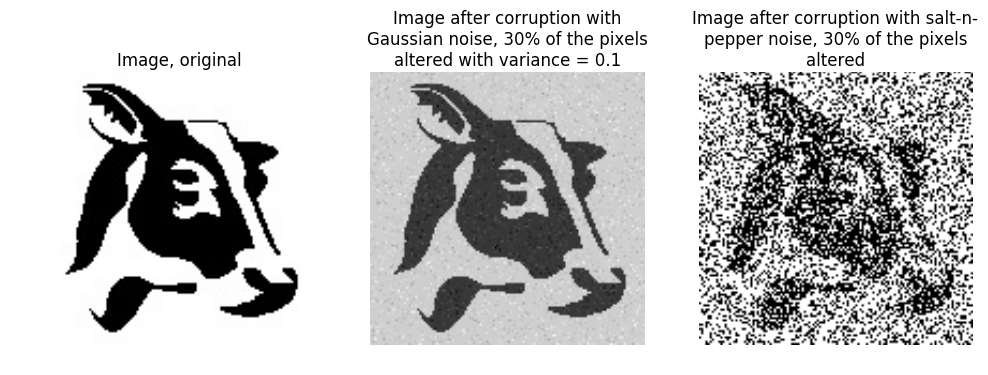

In [3]:
# proportion of pixels to alter
prop = 0.3
varSigma = 0.1

from numpy import genfromtxt
im4 = genfromtxt('im4.csv', delimiter =',')
im4_G = genfromtxt('im4_G.csv', delimiter =',')
im4_S = genfromtxt('im4_S.csv', delimiter =',')

# im1 = imread("../images/manan_grey_resize.jpg")
# im1, im1_G, im1_S = shrink_corrupt_images(im1, prop, varSigma)
# im1_title1, im1_title2, im1_title3 = create_corrupt_titles(prop, varSigma, 1)

# im2 = imread("../images/mike_grey_resize.jpg")
# im2, im2_G, im2_S = shrink_corrupt_images(im2, prop, varSigma)
# im2_title1, im2_title2, im2_title3 = create_corrupt_titles(prop, varSigma, 2)

# im4 = imread("../images/cow_grey_resize.jpg")
# im4, im4_G, im4_S = shrink_corrupt_images(im4, prop, varSigma)
im4_title1, im4_title2, im4_title3 = create_corrupt_titles(prop, varSigma, 4)

# %store -r im4
# %store -r im4_G
# %store -r im4_S

# display_three_images(im1, im1_title1, im1_G, im1_title2, im1_S, im1_title3)
# display_three_images(im2, im2_title1, im2_G, im2_title2, im2_S, im2_title3)
display_three_images(im4, im4_title1, im4_G, im4_title2, im4_S, im4_title3)

In [4]:
def neighbours(i,j,M,N,size):
    if size==4:
        if (i==0 and j==0):
            n=[(0,1), (1,0)]
        elif i==0 and j==N-1:
            n=[(0,N-2), (1,N-1)]
        elif i==M-1 and j==0:
            n=[(M-1,1), (M-2,0)]
        elif i==M-1 and j==N-1:
            n=[(M-1,N-2), (M-2,N-1)]
        elif i==0:
            n=[(0,j-1), (0,j+1), (1,j)]
        elif i==M-1:
            n=[(M-1,j-1), (M-1,j+1), (M-2,j)]
        elif j==0:
            n=[(i-1,0), (i+1,0), (i,1)]
        elif j==N-1:
            n=[(i-1,N-1), (i+1,N-1), (i,N-2)]
        else:
            n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
        return n
    if size==8:
        if (i==0 and j==0):
            n=[(0,1), (1,0), (1,1)]
        elif i==0 and j==N-1:
            n=[(0,N-2), (1,N-1), (1, N-2)]
        elif i==M-1 and j==0:
            n=[(M-1,1), (M-2,0), (M-2, 1)]
        elif i==M-1 and j==N-1:
            n=[(M-1,N-2), (M-2,N-1), (M-2, N-2)]
        elif i==0:
            n=[(0,j-1), (0,j+1), (1,j), (1,j-1), (1,j+1)]
        elif i==M-1:
            n=[(M-1,j-1), (M-1,j+1), (M-2,j), (M-2,j-1), (M-2,j+1)]
        elif j==0:
            n=[(i-1,0), (i+1,0), (i,1), (i-1,1), (i+1,1)]
        elif j==N-1:
            n=[(i-1,N-1), (i+1,N-1), (i,N-2), (i-1, N-2), (i+1, N-2)]
        else:
            n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1), (i-1,j-1), (i-1,j+1), (i+1,j-1), (i+1, j+1)]
        return n

In [7]:
def likeli_single_pos_neg(image, point):
    k = np.copy(image)
    k = 2*(k - 0.5) 
    return np.exp(k[point]), np.exp(-1 * k[point])

def prior_pos_neg(xImage, point, wHigh, wLow):
    expSum_pos = 0
    expSum_neg = 0
    H, W = heightWidth(xImage)
    i, j = point[0], point[1]
    ns = neighbours(i, j, H, W, size=4)
    for neighbour in ns:
        xImage[point] = 1
        if(xImage[point] == xImage[neighbour]):
            expSum_pos += xImage[neighbour] * xImage[point] * wHigh
        else:
            expSum_pos += xImage[neighbour] * xImage[point] * wLow
        xImage[point] = -1
        if(xImage[point] == xImage[neighbour]):
            expSum_neg += xImage[neighbour] * xImage[point] * wHigh
        else:
            expSum_neg += xImage[neighbour] * xImage[point] * wLow
    return np.exp(expSum_pos), np.exp(expSum_neg)                


def condProb(image, point, ximage, wHigh, wLow):
    LP, LN = likeli_single_pos_neg(image, point)
    PP, PN = prior_pos_neg(ximage, point, wHigh, wLow)
    numerator = LP * PP
    denominator = LN * PN
    return np.divide(numerator, numerator+denominator)

def GibbsICM(image):
    H, W = heightWidth(image)
    X = np.zeros((H, W))
    for i in range(H):
        for j in range(W):
            if (image.item((i, j)) == 1):
                np.put(X, (i, j), 1)
            elif (image.item((i, j)) == 0):
                np.put(X, (i, j), -1)
                
    for i in range(1):
        for i in range(H):
            for j in range(W):
                prob = condProb(image,(i,j),x)
                t = np.random.uniform(0,1)
                if prob > t:
                    np.put(x,(i,j),1)
                else:
                    np.put(x,(i,j),-1)
                    
    return x

def updateImage(image, xImage, point, wHigh, wLow):
    prob = condProb(image, point, xImage, wHigh, wLow)
    t = np.random.uniform(0, 1)
    if(prob > t):
        xImage[point] = 1
    else:
        xImage[point] = -1
    return xImage

def GibbsICM2(image, wHigh, wLow, lim, random, display):
    H, W = heightWidth(image)
    X = np.copy(image)
    X[X > 0.5] = 1
    X[X <= 0.5] = -1
    if(display == True):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.imshow(image, cmap='gray')
        ax.set_title("original image corrupted by noise")
        plt.show()
    for iteration in range(lim):        
        for i in range(H):
            for j in range(W):
                if(random==True):
                    m = np.random.randint(H)
                    n = np.random.randint(W)
                    X = updateImage(image, X, (m, n), wHigh, wLow)
                else:
                    X = updateImage(image, X, (i, j), wHigh, wLow)
        if(display == True):
            fig2 = plt.figure()
            ax = fig2.add_subplot(111)
            ax.imshow(X, cmap='gray')
            title = "image after " + str(iteration+1) + " iterations of Gibbs"
            ax.set_title(title)
            plt.show()      
    return X

# def GibbsICM2Saver(image, wHigh, wLow, lim, random):
#     H, W = heightWidth(image)
#     X = np.copy(image)
#     X[X > 0.5] = 1
#     X[X <= 0.5] = -1
#     X1 = np.copy(X)
#     X2 = np.copy(X)
#     for iteration in range(lim):        
#         for i in range(H):
#             for j in range(W):
#                 if(random==True):
#                     m = np.random.randint(H)
#                     n = np.random.randint(W)
#                     X = updateImage(image, X, (m, n), wHigh, wLow)
#                 else:
#                     X = updateImage(image, X, (i, j), wHigh, wLow)
#         if(iteration%3 == 0):
#             X1 = np.copy(X)
#         if(iteration%3 == 1):
#             X2 = np.copy(X)
#         if(iteration%3 == 2):
#         t1, t2 = create_denoise_titles(1, iterations+1)
#         f1 = "../images/q1/im4_g_Gibbs_non_random" + str(iterations+1)
#         f2 = "../images/q1/im4_s_Gibbs_non_random" + str(iterations+1)
#         if (random == True):
#             f1 = "../images/q1/im4_g_Gibbs_random" + str(iterations+1)
#             f2 = "../images/q1/im4_s_Gibbs_random" + str(iterations+1)
#         if(nType == 'G'):

#             save_three_images(im4, im4_title1, image, im4_title2, X, t1, f1)
#         elif(nType == 'S'):
#             save_three_images(im4, im4_title1, image, im4_title2, X, t2, f2)
#     return X

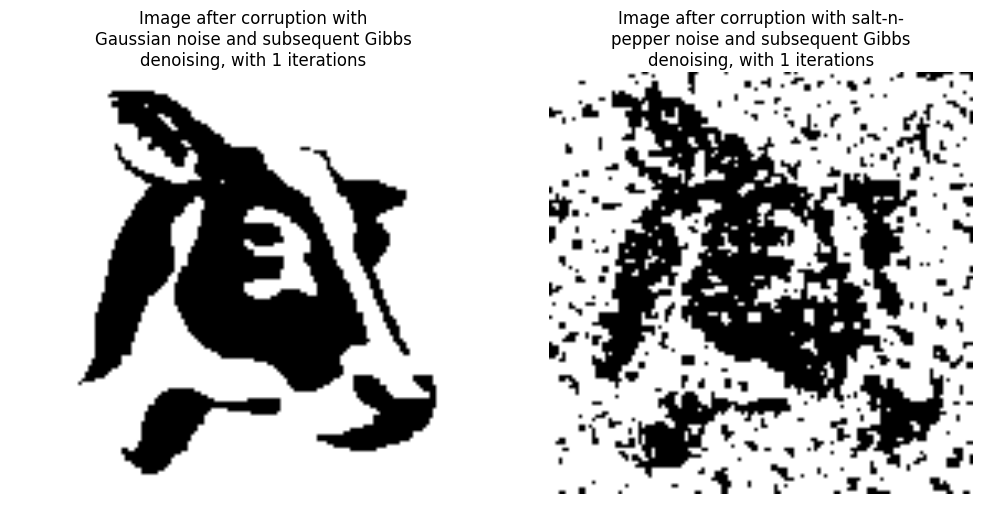

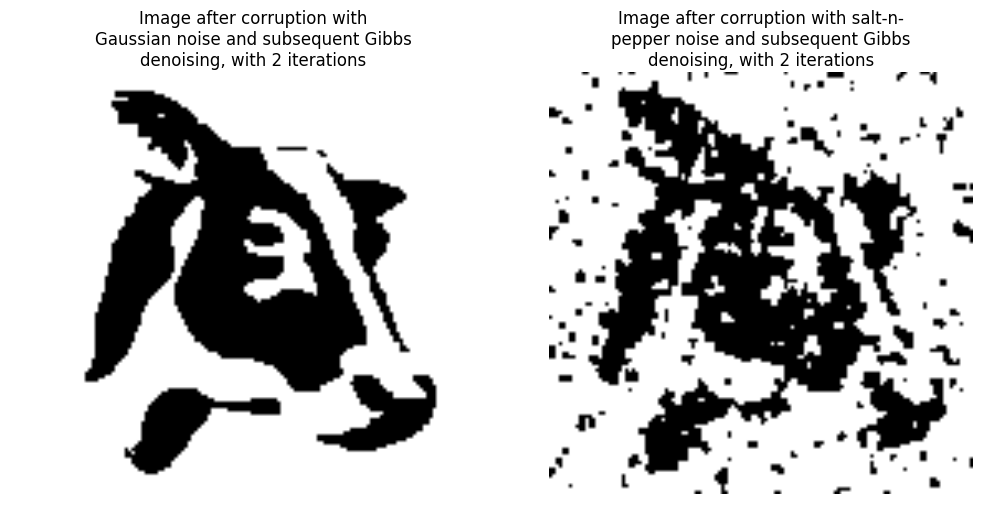

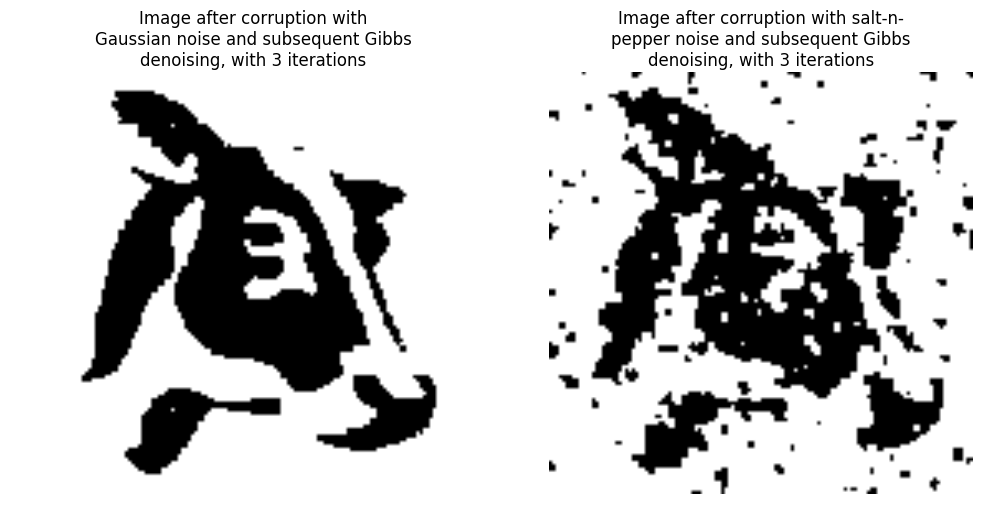

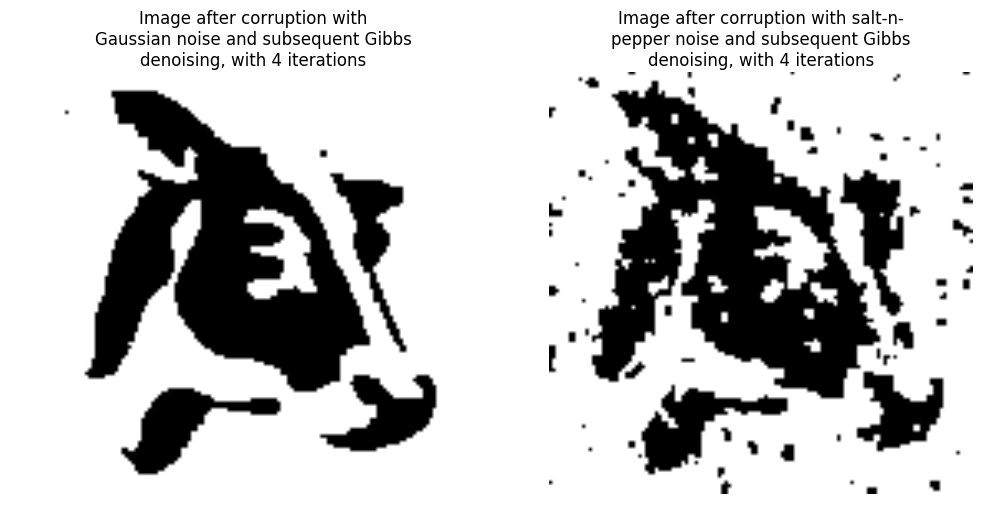

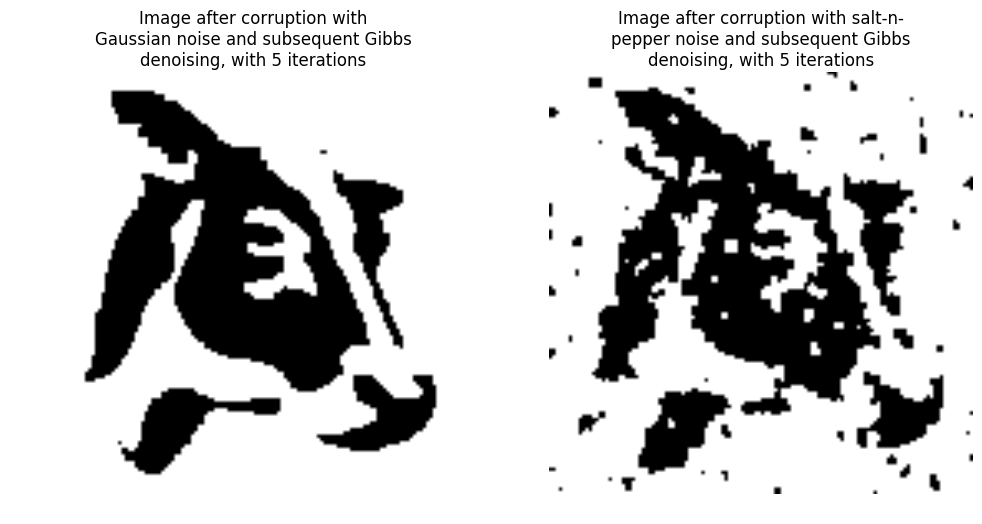

In [10]:
for iters in range(5):
    iters += 1
    wHigh = 1
    wLow = 1

#     im1_G_denoised = GibbsICM2(im1_G, wHigh, wLow, iters, random = False, display = False)
#     im1_S_denoised = GibbsICM2(im1_S, wHigh, wLow, iters, random = False, display = False)
#     im1_G_denoised_title, im1_S_denoised_title = create_denoise_titles(1, iters, random = False)

#     im2_G_denoised = GibbsICM2(im2_G, wHigh, wLow, iters, random = False, display = False)
#     im2_S_denoised = GibbsICM2(im2_S, wHigh, wLow, iters, random = False, display = False)
#     im2_G_denoised_title, im2_S_denoised_title = create_denoise_titles(2, iters, random = False)

    im4_G_denoised = GibbsICM2(im4_G, wHigh, wLow, iters, random = False, display = False)
    im4_S_denoised = GibbsICM2(im4_S, wHigh, wLow, iters, random = False, display = False)
#     im4_G_denoised_title, im4_S_denoised_title = create_denoise_titles(2, iters, random = False)

#     display_three_images(im1, im1_title1, im1_G, im1_title2, im1_G_denoised, im1_G_denoised_title)
#     display_three_images(im1, im1_title1, im1_S, im1_title3, im1_S_denoised, im1_S_denoised_title)
#     display_three_images(im2, im2_title1, im2_G, im2_title2, im2_G_denoised, im2_G_denoised_title)
#     display_three_images(im2, im2_title1, im2_S, im2_title3, im2_S_denoised, im2_S_denoised_title)
    
#     t1 = "../images/q2/im1_g_Gibbs_non_random" + str(iters)
#     t2 = "../images/q2/im1_s_Gibbs_non_random" + str(iters)
#     t3 = "../images/q2/im2_g_Gibbs_non_random" + str(iters)
#     t4 = "../images/q2/im2_s_Gibbs_non_random" + str(iters)
#     t5 = "../images/q2/im4_g_Gibbs_non_random" + str(iters)
#     t6 = "../images/q2/im4_s_Gibbs_non_random" + str(iters)
    
#     save_three_images(im1, im1_title1, im1_G, im1_title2, im1_G_denoised, im1_G_denoised_title, t1)
#     save_three_images(im1, im1_title1, im1_S, im1_title3, im1_S_denoised, im1_S_denoised_title, t2)
#     save_three_images(im2, im2_title1, im2_G, im2_title2, im2_G_denoised, im2_G_denoised_title, t3)
#     save_three_images(im2, im2_title1, im2_S, im2_title3, im2_S_denoised, im2_S_denoised_title, t4)
#     save_three_images(im4, im4_title1, im4_G, im4_title2, im4_G_denoised, im4_G_denoised_title, t5)
#     save_three_images(im4, im4_title1, im4_S, im4_title3, im4_S_denoised, im4_S_denoised_title, t6)


#     im1_G_denoised_random = GibbsICM2(im1_G, wHigh, wLow, iters, random = True, display = False)
#     im1_S_denoised_random = GibbsICM2(im1_S, wHigh, wLow, iters, random = True, display = False)
#     im1_G_denoised_random_title, im1_S_denoised_random_title = create_denoise_titles(1, iters, random = True)

#     im2_G_denoised_random = GibbsICM2(im2_G, wHigh, wLow, iters, random = True, display = False)
#     im2_S_denoised_random = GibbsICM2(im2_S, wHigh, wLow, iters, random = True, display = False)
#     im2_G_denoised_random_title, im2_S_denoised_random_title = create_denoise_titles(2, iters, random = True)
    
#     im4_G_denoised_random = GibbsICM2(im4_G, wHigh, wLow, iters, random = True, display = False)
#     im4_S_denoised_random = GibbsICM2(im4_S, wHigh, wLow, iters, random = True, display = False)
#     im4_G_denoised_random_title, im4_S_denoised_random_title = create_denoise_titles(2, iters, random = True)

#     display_three_images(im1, im1_title1, im1_G, im1_title2, im1_G_denoised_random, im1_G_denoised_random_title)
#     display_three_images(im1, im1_title1, im1_S, im1_title3, im1_S_denoised_random, im1_S_denoised_random_title)
#     display_three_images(im2, im2_title1, im2_G, im2_title2, im2_G_denoised_random, im2_G_denoised_random_title)
#     display_three_images(im2, im2_title1, im2_S, im2_title3, im2_S_denoised_random, im2_S_denoised_random_title)
    
#     tr1 = "../images/q2/im1_g_Gibbs_random" + str(iters)
#     tr2 = "../images/q2/im1_s_Gibbs_random" + str(iters)
#     tr3 = "../images/q2/im2_g_Gibbs_random" + str(iters)
#     tr4 = "../images/q2/im2_s_Gibbs_random" + str(iters)
#     tr5 = "../images/q2/im4_g_Gibbs_random" + str(iters)
#     tr6 = "../images/q2/im4_s_Gibbs_random" + str(iters)   
    
#     save_three_images(im1, im1_title1, im1_G, im1_title2, im1_G_denoised_random, im1_G_denoised_random_title, tr1)
#     save_three_images(im1, im1_title1, im1_S, im1_title3, im1_S_denoised_random, im1_S_denoised_random_title, tr2)
#     save_three_images(im2, im2_title1, im2_G, im2_title2, im2_G_denoised_random, im2_G_denoised_random_title, tr3)
#     save_three_images(im2, im2_title1, im2_S, im2_title3, im2_S_denoised_random, im2_S_denoised_random_title, tr4)
#     save_three_images(im4, im4_title1, im4_G, im4_title2, im4_G_denoised_random, im4_G_denoised_random_title, tr5)
#     save_three_images(im4, im4_title1, im4_S, im4_title3, im4_S_denoised_random, im4_S_denoised_random_title, tr6)
    
    title1, title2 = create_denoise_titles(4, iters, False)
    fpath = "../images/q2/im4_GS_Gibbs_" + str(iters)
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(121)
    ax1.set_title("\n".join(wrap(title1, 35)))
    ax1.axis('off')
    ax1.imshow(im4_G_denoised,cmap='gray')
    
    ax2 = fig.add_subplot(122)
    ax2.set_title("\n".join(wrap(title2, 35)))
    ax2.axis('off')
    ax2.imshow(im4_S_denoised,cmap='gray')
    
    plt.savefig(fpath,bbox_inches='tight')

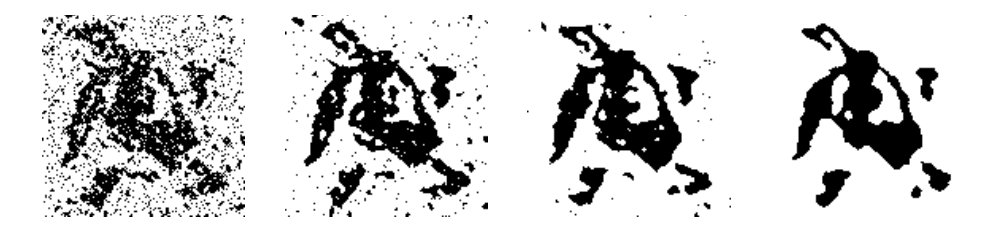

In [7]:
for iters in range(12):
    iters += 1
#     im4_G_denoised = GibbsICM2(im4_G, wHigh, wLow, iters, random = False, display = False)
    im4_S_denoised = GibbsICM2(im4_S, wHigh, wLow, iters, random = True, display = False)
    if(iters == 1):
        im4_S_denoised1 = im4_S_denoised
    if(iters == 3):
        im4_S_denoised3 = im4_S_denoised
    if(iters == 5):
        im4_S_denoised5 = im4_S_denoised
    if(iters == 12):
        im4_S_denoised12 = im4_S_denoised
        fpath = "../images/q2/im4_s_Gibbs_random_comparison"
        fig = plt.figure(figsize=(12, 8))
        ax1 = fig.add_subplot(141)
#         ax1.set_title("\n".join(wrap(title1, 35)))
        ax1.axis('off')
        ax1.imshow(im4_S_denoised1,cmap='gray')

        ax2 = fig.add_subplot(142)
#         ax2.set_title("\n".join(wrap(title2, 35)))
        ax2.axis('off')
        ax2.imshow(im4_S_denoised3,cmap='gray')

        ax3 = fig.add_subplot(143)
#         ax3.set_title("\n".join(wrap(title3, 35)))
        ax3.axis('off')
        ax3.imshow(im4_S_denoised5,cmap='gray')
        
        ax4 = fig.add_subplot(144)
#         ax3.set_title("\n".join(wrap(title3, 35)))
        ax4.axis('off')
        ax4.imshow(im4_S_denoised12,cmap='gray')

        plt.savefig(fpath,bbox_inches='tight')